In [2]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [11]:
import sys

dir_github = r'/media/rich/Home_Linux_partition/github_repos/'
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [80]:
from pathlib import Path
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy

In [14]:
dir_Ian = Path(r'/media/rich/bigSSD/other lab data/Ian_ROIs/ScritchData').resolve()

In [17]:
paths_Ian = path_helpers.get_numeric_contents(dir_Ian)[0]

In [60]:
stat_mats_Ian = [scipy.io.loadmat(path, simplify_cells=True) for path in paths_Ian]
stats_Ian = [stat['stat'] for stat in stat_mats_Ian]

In [33]:
stats_Ian[0]['stat'][0].keys()

dict_keys(['ipix', 'ypix', 'xpix', 'lam', 'lambda', 'npix', 'med', 'neuropilCoefficient', 'baseline', 'footprint', 'mrs', 'mrs0', 'cmpct', 'aspect_ratio', 'ellipse', 'mimgProj', 'mimgProjAbs', 'isoverlap', 'radius', 'ipix_neuropil', 'dFstat', 'skew', 'std', 'maxMinusMed', 'top5pcMinusMed', 'blockstarts', 'iplane', 'iscell', 'noiseLevel', 'redcell', 'redprob', 'notred', 'cellProb'])

In [42]:
def statFile_to_spatialFootprints(path_statFile=None, statFile=None, out_height_width=[36,36], max_footprint_width=241, plot_pref=True, one_indexed=False):
    """
    Converts a stat file to a list of spatial footprint images.
    RH 2021

    Args:
        path_statFile (pathlib.Path or str):
            Path to the stat file.
            Optional: if statFile is provided, this
             argument is ignored.
        statFile (dict):
            Suite2p stat file dictionary
            Optional: if path_statFile is provided, this
             argument is ignored.
        out_height_width (list):
            [height, width] of the output spatial footprints.
        max_footprint_width (int):
            Maximum width of the spatial footprints.
        plot_pref (bool):
            If True, plots the spatial footprints.
    
    Returns:
        sf_all (list):
            List of spatial footprints images
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    assert out_height_width[0]%2 == 0 and out_height_width[1]%2 == 0 , "RH: 'out_height_width' must be list of 2 EVEN integers"
    assert max_footprint_width%2 != 0 , "RH: 'max_footprint_width' must be odd"
    if statFile is None:
        stat = np.load(path_statFile, allow_pickle=True)
    else:
        stat = statFile
        
    if one_indexed:
        idx_offset = -1
    else:
        idx_offset = 0
    
    n_roi = len(stat)
    
    # sf_big: 'spatial footprints' prior to cropping. sf is after cropping
    sf_big_width = max_footprint_width # make odd number
    sf_big_mid = sf_big_width // 2

    sf_big = np.zeros((n_roi, sf_big_width, sf_big_width))
    for ii in range(n_roi):
        sf_big[ii , stat[ii]['ypix'] - np.int16(stat[ii]['med'][0]) + sf_big_mid + idx_offset, stat[ii]['xpix'] - np.int16(stat[ii]['med'][1]) + sf_big_mid + idx_offset] = stat[ii]['lam'] # (dim0: ROI#) (dim1: y pix) (dim2: x pix)

    sf = sf_big[:,  
                sf_big_mid - out_height_width[0]//2:sf_big_mid + out_height_width[0]//2,
                sf_big_mid - out_height_width[1]//2:sf_big_mid + out_height_width[1]//2]
    if plot_pref:
        plt.figure()
        plt.imshow(np.max(sf, axis=0)**0.2)
        plt.title('spatial footprints cropped MIP^0.2')
    
    return sf

In [66]:
def import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=None,
    frame_height=512, 
    frame_width=1024,
    dtype=np.uint8,
    ):
    """
    Imports and converts multiple stat files to spatial footprints
     suitable for CellReg.
    Output will be a list of arrays of shape (n_roi, height, width).
    RH 2022
    """

    isInt = np.issubdtype(dtype, np.integer)

    if paths_statFiles is not None:
        stats = [np.load(path, allow_pickle=True) for path in paths_statFiles]
    else:
        stats = statFiles
    
    num_rois = [len(stat) for stat in stats]
    sf_all_list = [np.zeros((n_roi, frame_height, frame_width), dtype) for n_roi in num_rois]
    for ii, stat in enumerate(stats):
        for jj, roi in enumerate(stat):
            lam = np.array(roi['lam'])
            if isInt:
                lam = dtype(lam / lam.sum() * np.iinfo(dtype).max)
            else:
                lam = lam / lam.sum()
            sf_all_list[ii][jj, roi['ypix'], roi['xpix']] = lam
    return sf_all_list

In [68]:
sfFOVs = import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=stats_Ian,
    frame_height=512, 
    frame_width=1024,
    dtype=np.uint8,
)

In [122]:
def sf_to_FOV(sfs, eps=1e-20):

    FOV = copy.copy(sfs)
    FOV = FOV / (FOV.max((1,2), keepdims=True) + eps)
    FOV = FOV.max(0)
    return FOV

In [125]:
FOVs = [sf_to_FOV(sf) for sf in sfFOVs]

<IPython.core.display.Javascript object>


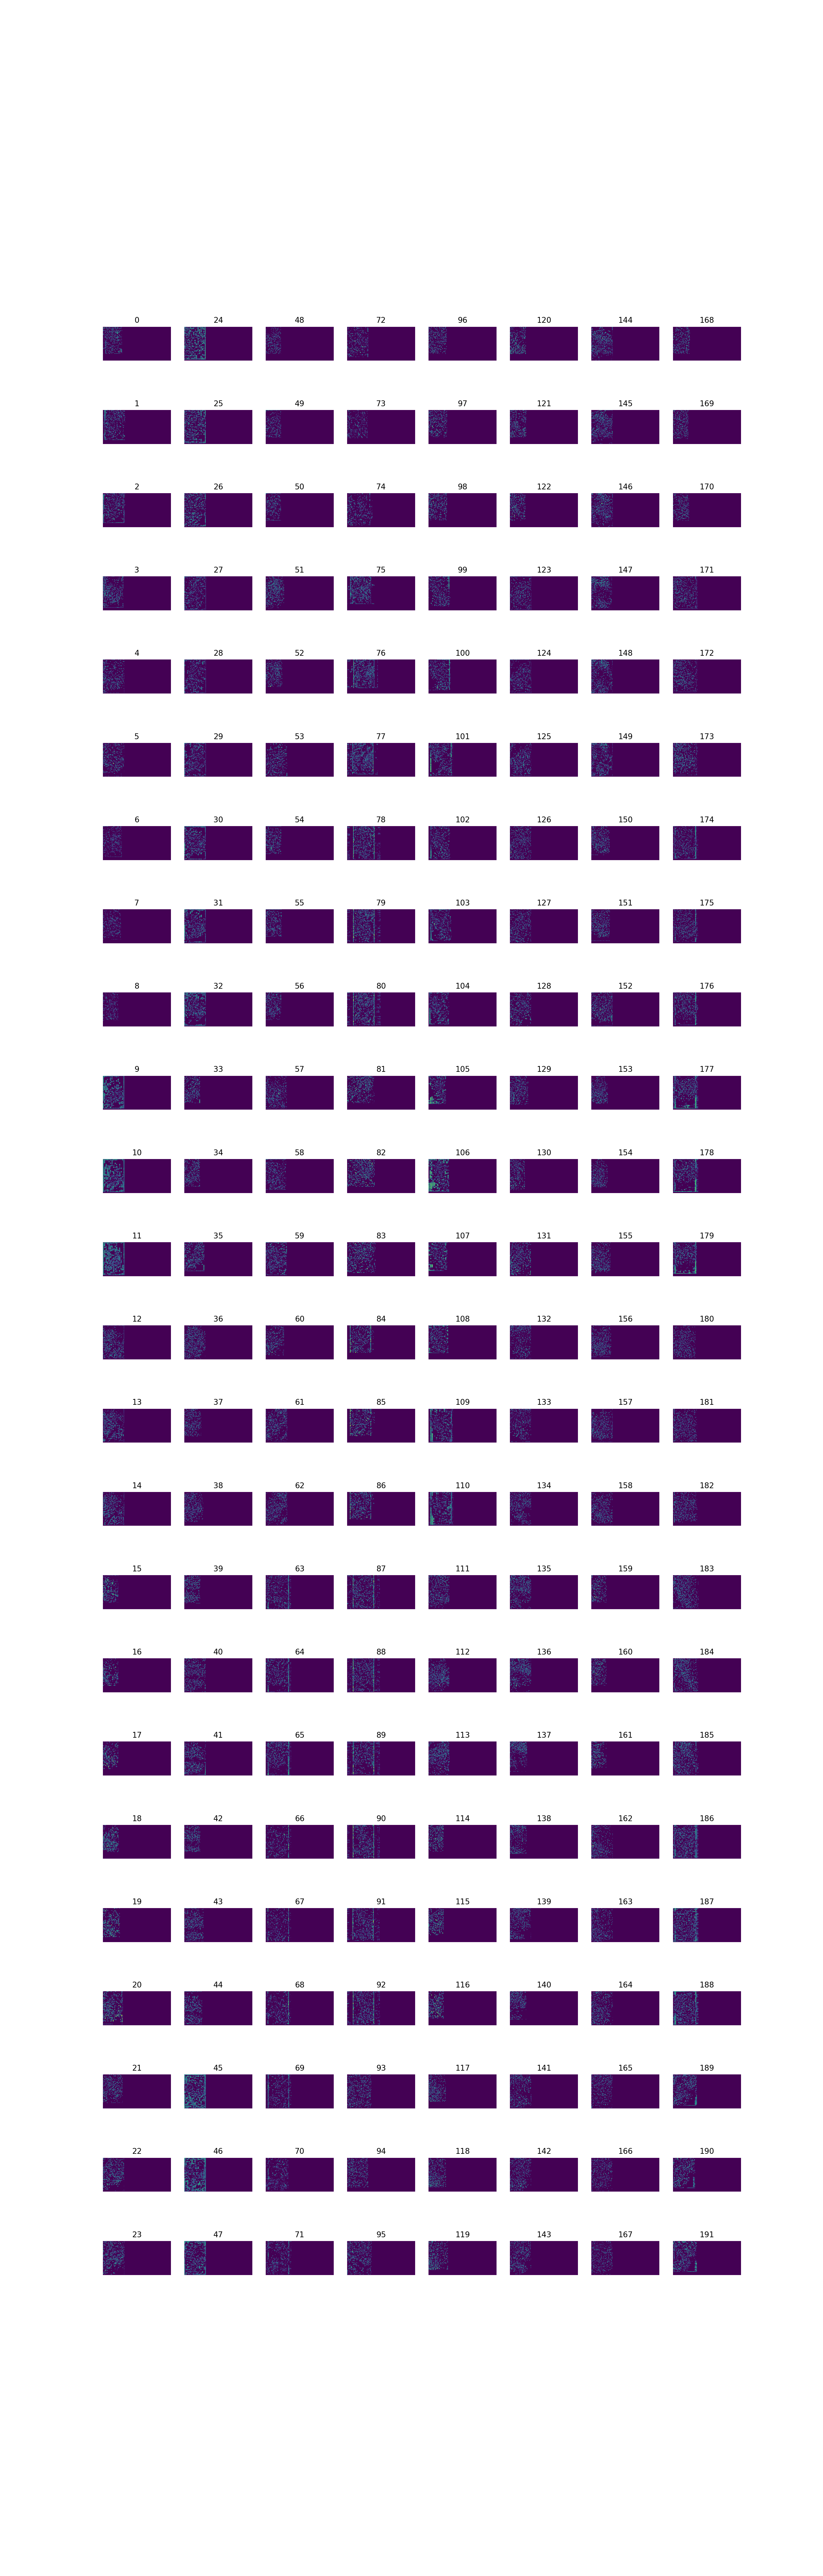

(<Figure size 640x480 with 192 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'24'}>,
         <AxesSubplot:title={'center':'48'}>,
         <AxesSubplot:title={'center':'72'}>,
         <AxesSubplot:title={'center':'96'}>,
         <AxesSubplot:title={'center':'120'}>,
         <AxesSubplot:title={'center':'144'}>,
         <AxesSubplot:title={'center':'168'}>],
        [<AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'25'}>,
         <AxesSubplot:title={'center':'49'}>,
         <AxesSubplot:title={'center':'73'}>,
         <AxesSubplot:title={'center':'97'}>,
         <AxesSubplot:title={'center':'121'}>,
         <AxesSubplot:title={'center':'145'}>,
         <AxesSubplot:title={'center':'169'}>],
        [<AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'26'}>,
         <AxesSubplot:title={'center':'50'}>,
         <AxesSubplot:title={'center':'74'}>,
         <AxesSubplot:title={'center'

In [130]:
plotting_helpers.plot_image_grid(
    images = FOVs,
    grid_shape = (24,8),
    labels = range(0,192)
)

In [147]:
bad_sessions = [9,10,11,24,25,32,45,46,47,64,65,66,67,68,69,76,78,79,80,84,87,88,89,90,91,92,100,101,105,106,107,109,110,174,175,176,177,178,179,187,188]
n_sessions = len(FOVs)
good_sessions = np.arange(n_sessions)
good_sessions = np.array(good_sessions[np.isin(good_sessions, bad_sessions, invert=True)])

In [166]:
sf_raw_Ian = [
    statFile_to_spatialFootprints(
        statFile=stat, 
        out_height_width=[36,36],
        max_footprint_width=241, 
        plot_pref=False, 
        one_indexed=True
    ) for stat in stats_Ian
]

In [167]:
sf_Ian = [val for ii,val in enumerate(sf_raw_Ian) if ii in good_sessions]

In [168]:
sf_Ian_concat = np.concatenate(sf_Ian, axis=0)